In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')

In [3]:
# Lectura de los datos
clustering = pd.read_csv('../models/clustering.csv', index_col=['country'])
clustering.sample(5, random_state=777)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,clusters
country,,,,,,,,,,
Bangladesh,49.40,16.00,3.52,21.80,2440,7.14,70.40,2.33,758,Desarrollo precario
Bhutan,42.70,42.50,5.20,70.70,6420,5.99,72.10,2.38,2180,Emergente
Malta,6.80,153.00,8.65,154.00,28300,3.83,80.30,1.36,21100,Desarrollado
Tonga,17.40,12.40,5.07,60.30,4980,3.68,69.90,3.91,3550,Emergente
Italy,4.00,25.20,9.53,27.20,36200,0.32,81.70,1.46,35800,Desarrollado


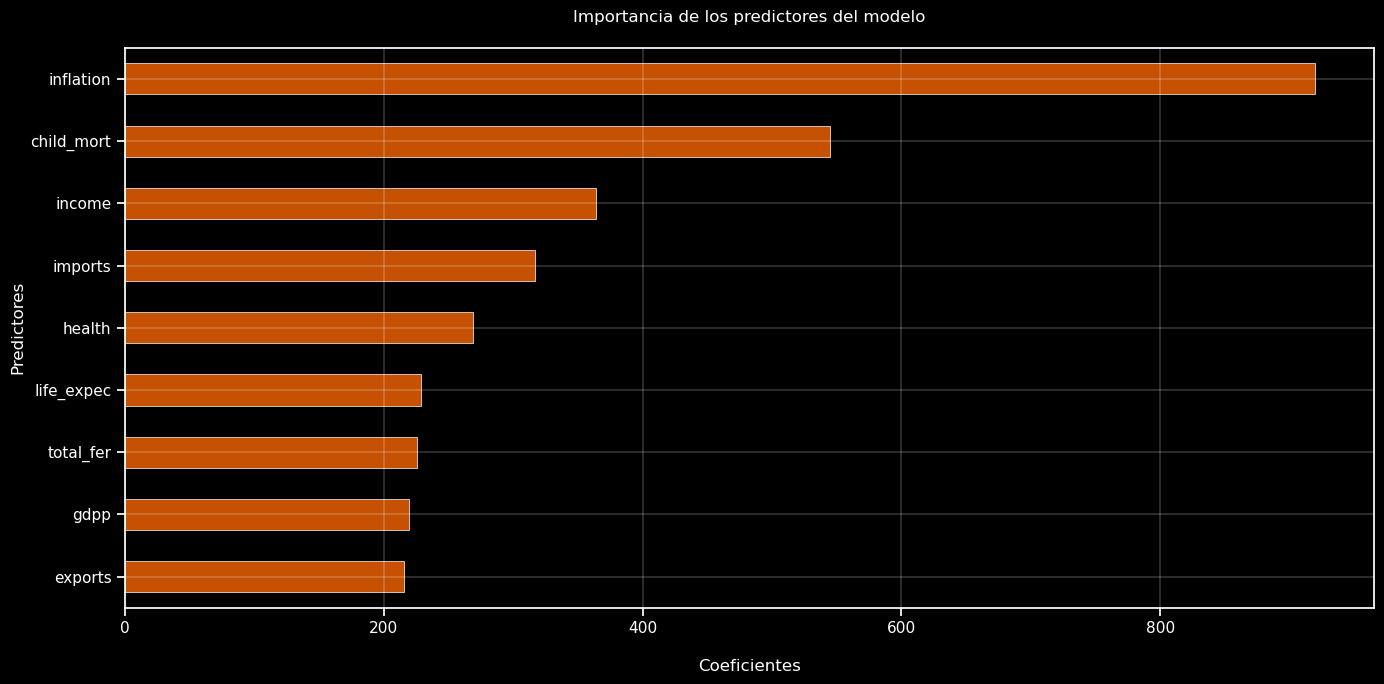

In [4]:
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Separamos los features y el target
X = clustering.loc[:, clustering.columns != 'clusters']
y = clustering.loc[:, clustering.columns == 'clusters'].squeeze()

categorical_feature = X.select_dtypes(include=['object', 'category']).columns.tolist()
X[categorical_feature] = X[categorical_feature].astype('category')

# Pesos de las muestras
sample_weight = compute_sample_weight(class_weight='balanced', y=y)

# Instanciamos nuestro clasificador
lgbm = LGBMClassifier(objective='multiclass',
                      n_jobs=-1,
                      is_unbalance=True,
                      verbose=-1,
                      random_state=42)

# Ajustamos el modelo
lgbm.fit(X, 
         y,
         categorical_feature=categorical_feature, 
         sample_weight=sample_weight)

# Pesos de los coeficientes
coeficientes = dict(zip(lgbm.feature_name_, [predictor for predictor in lgbm.feature_importances_]))
coef_df = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['coeficientes'])

# Graficar barras horizontales
coef_df.sort_values('coeficientes', ascending=True).plot.barh(figsize=(14, 7), color='xkcd:dark orange', width=0.5,
                                                              edgecolor='white', lw=0.5, legend=False)

# Agregar etiquetas y títulos
plt.title('Importancia de los predictores del modelo\n')
plt.xlabel('\nCoeficientes')
plt.ylabel('Predictores')
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()